In [1]:
import sys
sys.path.append("..")


In [2]:
from didgelab.calc.sim.cadsd import CADSD
from didgelab.calc.geo import Geo
from didgelab.calc.fft import do_fft, get_harmonic_maxima
import matplotlib.pyplot as plt
import os
import json
from didgelab.app import App

print(App.get_config())

{'sim.resolution': 2, 'sim.fmin': 30, 'sim.fmax': 1000, 'sim.impedance_type': 'output', 'n_threads': 8, 'log_level': 'info'}


TypeError: must be real number, not list

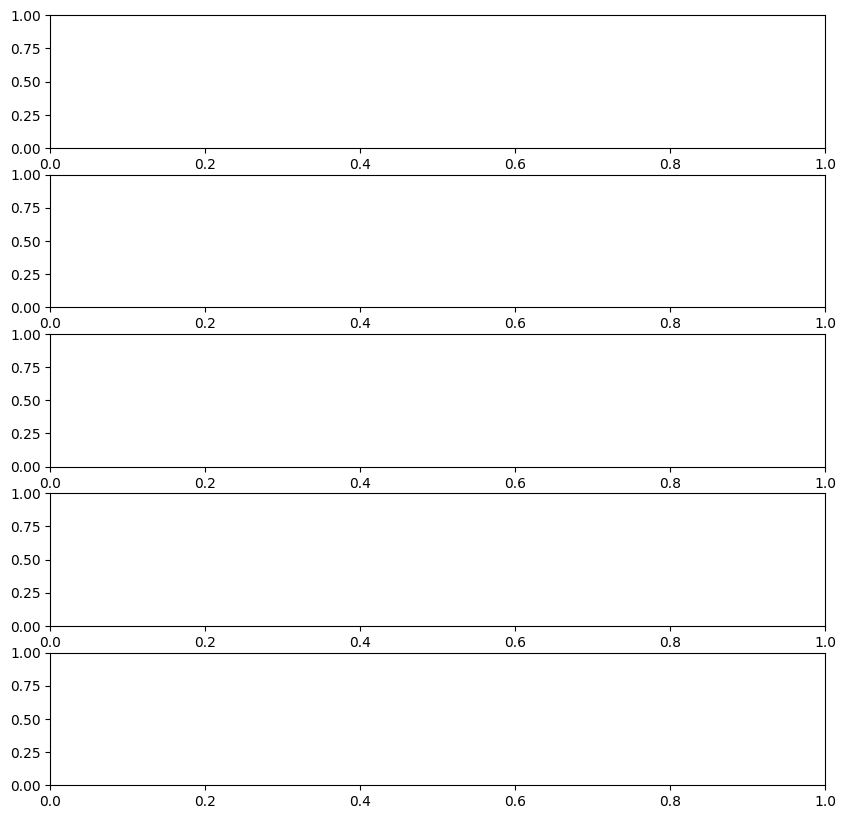

In [3]:
archive_path_json = "../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))

fig, axs = plt.subplots(len(archive), 1, figsize=(10,10))

didges = []

show_computed_ground_spectrum=True
show_computed_impedance_spectrum=False
show_original_fft=True
show_ground_peaks=True
show_fft_peaks=True
show_corrected_ground_spektrum=True
show_corrected_ground_peaks=True

colors = ['#8a3ffc', '#33b1ff', '#007d79', '#ff7eb6', '#fa4d56', '#fff1f1', '#6fdc8c', '#4589ff', '#d12771', '#d2a106', '#08bdba', '#bae6ff', '#ba4e00', '#d4bbff']

c1=1
c2=4
c3=2

for i in range(len(archive)):
    geo = json.load(open(os.path.join(archive_path, archive[i]["geometry"]), "r"))
    geo = Geo(geo)
    cadsd = geo.get_cadsd()
    
    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    
    if show_computed_ground_spectrum:
        axs[i].plot(ground_freqs, ground_vols, label="berechnet", color=colors[c1])

    sound_file = os.path.join(archive_path, archive[i]["audio-samples"]["neutral-sound"])
    freq, spectrum = do_fft(sound_file)
    spectrum = np.log2(spectrum)
    spectrum -= spectrum.min()
    spectrum /= spectrum.max()

    if show_original_fft:
        axs[i].plot(freq, spectrum, label=f"gemessen", color=colors[c2])
    
    if show_computed_impedance_spectrum:
        impedance_spektrum = cadsd.get_impedance_spektrum()
        impedance_freqs = impedance_spektrum.freq
        impedance_amps = impedance_spektrum.impedance
        impedance_amps -= impedance_amps.min()
        impedance_amps /= impedance_amps.max()
        axs[i].plot(impedance_freqs, impedance_amps, label=f"impedance")

    if show_fft_peaks:
        fft_maxima = get_harmonic_maxima(freq, spectrum)
        for m in fft_maxima:
            axs[i].axvline(x=m, color=colors[c2]) 
        
    if show_ground_peaks:
        ground_maxima = get_harmonic_maxima(ground_freqs, ground_vols)
        for m in ground_maxima:
            axs[i].axvline(x=m, color=colors[c1])

    # compute model with all shapes except this one
    train_indices = list(range(len(archive)))
    del train_indices[i]
    eval_indices = [i]
    regr, rms_before, rms_cor = train_and_evaluate(archive, train_indices, eval_indices)

    if show_corrected_ground_peaks:
        corrected_maxima_X = np.array(ground_maxima).reshape((-1,1))
        corrected_maxima = ground_maxima + regr.predict(corrected_maxima_X)
        for m in corrected_maxima:
            axs[i].axvline(x=m, color=colors[c3])
            
    if show_corrected_ground_spektrum:
        X = ground_freqs.reshape((-1,1))
        y = regr.predict(X)
        corrected_ground_freqs = ground_freqs + y
        axs[i].plot(corrected_ground_freqs, ground_vols, label=f"korrigiert", color=colors[c3])
        
    axs[i].legend()
    axs[i].set_title(archive[i]["name"])
            
fig.tight_layout()
plt.show()

In [8]:
import numpy as np

x=np.ones(10).reshape((-1,1))
np.concatenate(x)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
x=np.ones(10)
np.array(x)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])